In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as
from tensorflow.compat.v1.keras.optimizers import adam

In [52]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50 
CHANNELS = 3

In [53]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage", 
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE   
)

Found 2152 files belonging to 3 classes.


In [54]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [55]:
len(dataset)

68

In [56]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    print(image_batch[0].shape)
    

(32, 256, 256, 3)
[0 0 1 0 1 1 1 1 1 0 0 0 1 1 1 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 0 0]
(256, 256, 3)


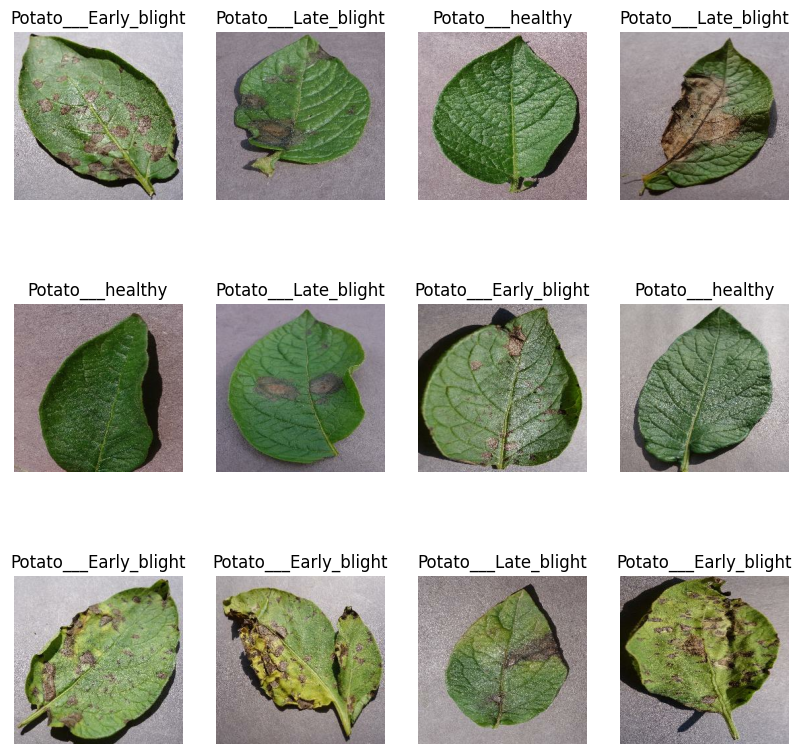

In [57]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    

In [58]:
len(dataset)

68

In [59]:
80% ==> training
20% ==> 10% validation, 10% test

SyntaxError: invalid syntax (829920516.py, line 1)

In [60]:
train_size = 0.8
len(dataset)*train_size


54.400000000000006

In [61]:
train_dataset = dataset.take(54)
len(train_dataset)

54

In [27]:
test_validate = dataset.skip(54)
len(test_validate)

14

In [28]:
validate_size = 0.1
len(dataset)*validate_size

6.800000000000001

In [32]:
validate_dataset = test_validate.take(6)
len(validate_dataset)

6

In [33]:
test_dataset = test_validate.skip(6)
len(test_dataset)

2

In [63]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds


In [64]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [65]:
len(train_ds)

54

In [43]:
len(val_ds)

6

In [44]:
len(test_ds)

8

In [66]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [68]:
#if the user inputs an image that is not 256 by 256 it handles the resize and rescale
resize_and_rescale = tf.keras.Sequential([
     layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
     layers.experimental.preprocessing.Rescaling(1.0/255)
 ])   

In [69]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2) 
])

In [74]:
#building the model
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    #the framing involves two i,e conv2d and pooling
    layers.Conv2D(32, (3,3), activation = "relu", input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = "relu"),
    layers.Dense(n_classes, activation = "softmax"), 
])
model.build(input_shape = input_shape)

In [75]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_7 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [77]:
model.compile(
    optimizer = "adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [78]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50


54/54 [==============================] - 154s 2s/step - loss: 0.8720 - accuracy: 0.5081 - val_loss: 0.7172 - val_accuracy: 0.6302
Epoch 2/50
54/54 [==============================] - 99s 2s/step - loss: 0.6150 - accuracy: 0.7014 - val_loss: 0.4983 - val_accuracy: 0.7760
Epoch 3/50
54/54 [==============================] - 99s 2s/step - loss: 0.4135 - accuracy: 0.8252 - val_loss: 0.4160 - val_accuracy: 0.8385
Epoch 4/50
54/54 [==============================] - 95s 2s/step - loss: 0.3286 - accuracy: 0.8663 - val_loss: 0.2784 - val_accuracy: 0.8750
Epoch 5/50
54/54 [==============================] - 87s 2s/step - loss: 0.2598 - accuracy: 0.8981 - val_loss: 0.4132 - val_accuracy: 0.8021
Epoch 6/50
54/54 [==============================] - 89s 2s/step - loss: 0.2804 - accuracy: 0.9010 - val_loss: 0.3536 - val_accuracy: 0.8802
Epoch 7/50
54/54 [==============================] - 87s 2s/step - loss: 0.2454 - accuracy: 0.9005 - val_loss: 0.2097 - val_accuracy: 0.9115
Epoch 8/50
54/54 

In [82]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 275ms/step - loss: 0.0076 - accuracy: 0.9961


In [83]:
scores

[0.007598800119012594, 0.99609375]

In [84]:
history

In [85]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [88]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [89]:
history.history["accuracy"]

[0.5081018805503845,
 0.7013888955116272,
 0.8252314925193787,
 0.8663194179534912,
 0.8981481194496155,
 0.9010416865348816,
 0.9004629850387573,
 0.9276620149612427,
 0.9184027910232544,
 0.9212962985038757,
 0.9340277910232544,
 0.9403935074806213,
 0.9479166865348816,
 0.9537037014961243,
 0.9513888955116272,
 0.9618055820465088,
 0.9600694179534912,
 0.9589120149612427,
 0.9612268805503845,
 0.9646990895271301,
 0.9728009104728699,
 0.9756944179534912,
 0.9733796119689941,
 0.9791666865348816,
 0.9751157164573669,
 0.9855324029922485,
 0.9861111044883728,
 0.9849537014961243,
 0.9594907164573669,
 0.9780092835426331,
 0.9855324029922485,
 0.9884259104728699,
 0.9872685074806213,
 0.9809027910232544,
 0.9901620149612427,
 0.9878472089767456,
 0.9901620149612427,
 0.9878472089767456,
 0.9913194179534912,
 0.9780092835426331,
 0.9785879850387573,
 0.9913194179534912,
 0.9872685074806213,
 0.9890046119689941,
 0.9878472089767456,
 0.9965277910232544,
 0.9890046119689941,
 0.9913194179

In [90]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

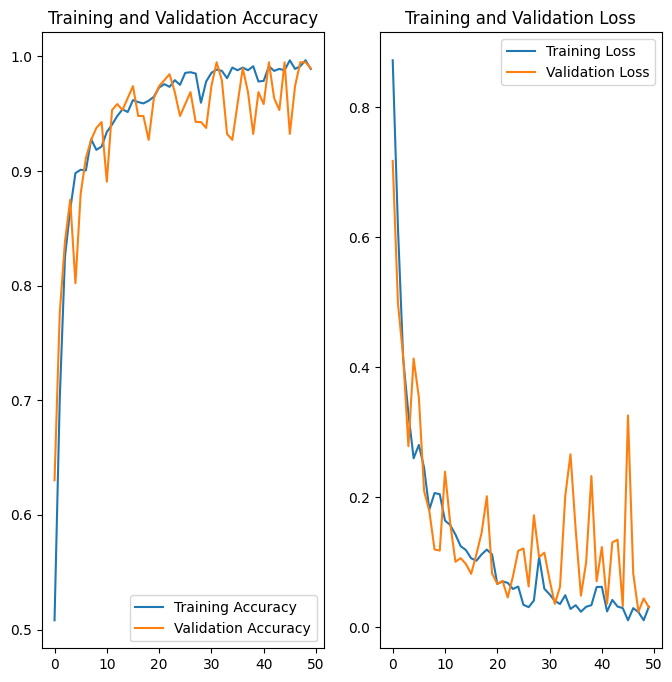

In [93]:
# plot chart for accuracy
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = "Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label = "Validation Accuracy")
plt.legend(loc = "lower right")
plt.title("Training and Validation Accuracy")

#plot chart for loss
plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = "Training Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc = "upper right")
plt.title("Training and Validation Loss")

plt.show()


In [106]:
np.argmax([1.2017284e-07,9.9999988e-01,3.5181393e-12])

1

first image to predict
first image's actual label:  Potato___Late_blight
1/1 [==============================] - 0s 302ms/step
Predicted label:  Potato___Late_blight


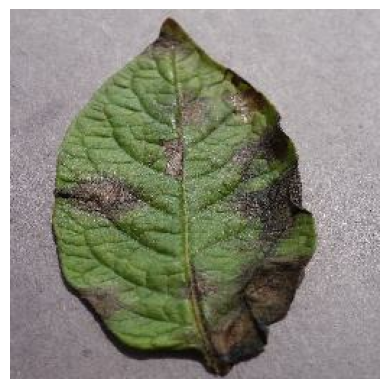

In [112]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    # plt.imshow(images_batch[0].numpy().astype("uint8")) shows the image itself
    # plt.axis("off") removes the axis on the picture

    # to show the rgb codes
    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label: ", class_names[first_label])
    plt.axis("off")

    batch_prediction = model.predict(images_batch)
    print("Predicted label: ", class_names[np.argmax(batch_prediction[0])])


    

In [128]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) ##creating a batch

    predictions =  model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100* (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 33ms/step


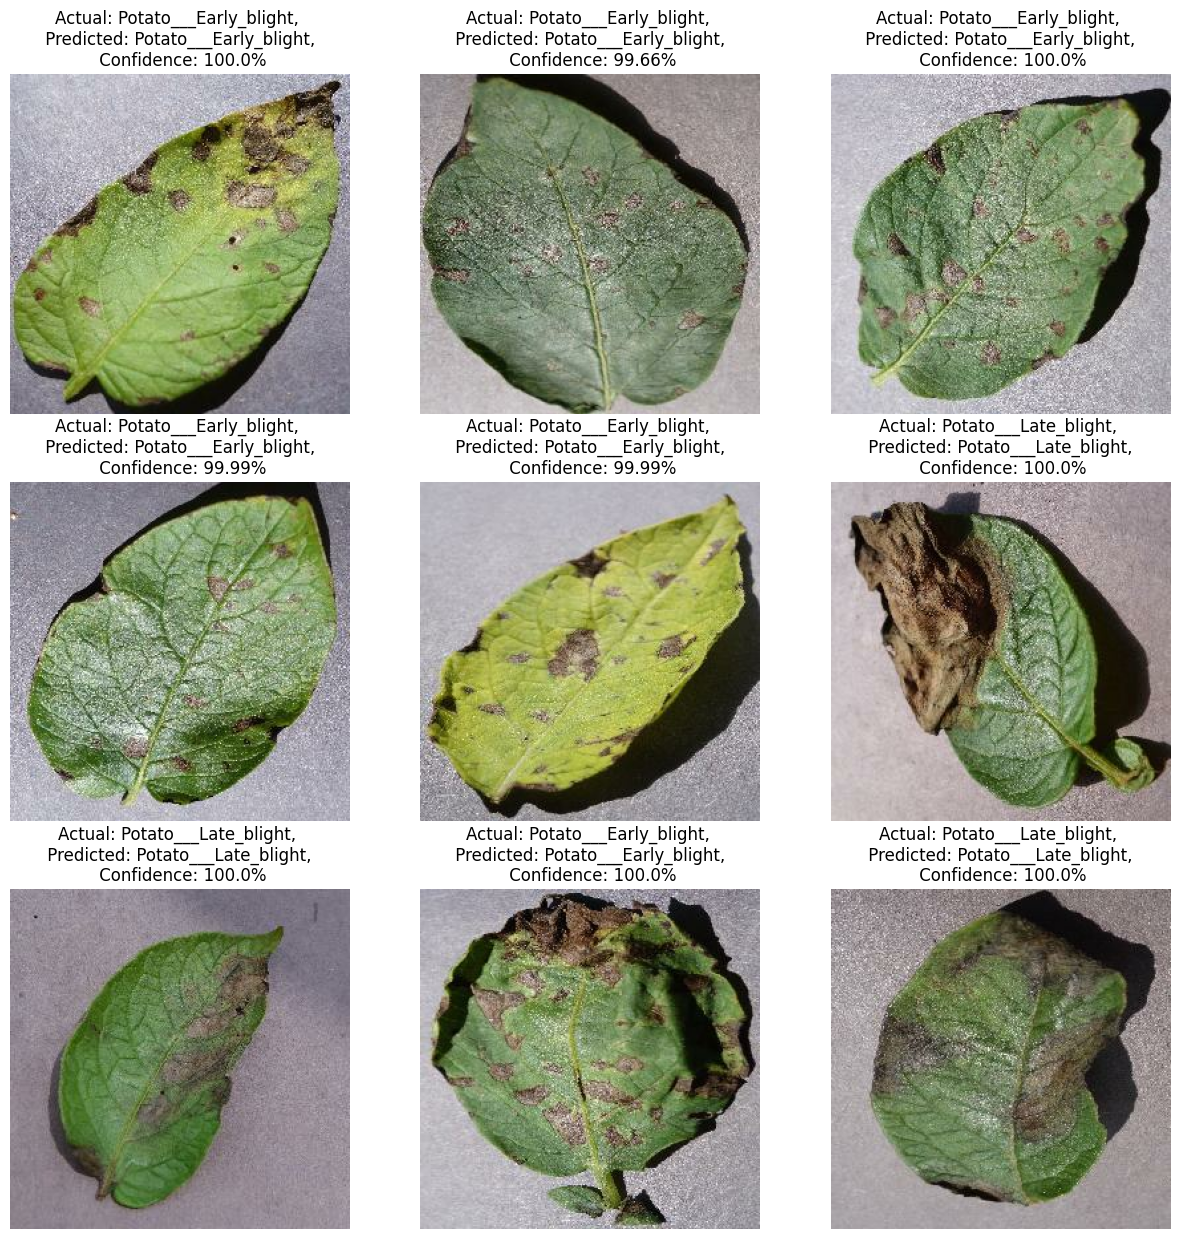

In [125]:
plt.figure(figsize = (15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        plt.axis("off")
        
        
        

In [127]:
#saving the different versions of models and also incase you change
#something you can save it differently
#model_version = 1
#model.save(f"../models/{model_version}")


#how to auto increment rather than the above method

import os
model_version = max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets
